google/vivit-b-16x2 <br>
https://huggingface.co/google/vivit-b-16x2 <br>
https://huggingface.co/docs/transformers/main/model_doc/vivit

# Import Library

In [1]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1


In [2]:
import torch
torch.autograd.set_detect_anomaly(True)

print('pytorch version', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pytorch version 2.5.1+cu121
GPU available: 0


In [3]:
#!nvcc --version

In [4]:
# For data augmentation
from torchvision import transforms

In [5]:
#!pip install -q transformers==4.35.0

In [6]:
import transformers

# For Tokenizers
from transformers import VivitImageProcessor, VivitConfig

# For Model
from transformers import VivitModel, VivitForVideoClassification

# For TPU
from transformers import set_seed
from torch.optim import AdamW

In [7]:
!pip install -q datasets #==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [8]:
# For Data Loaders
import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [9]:
#!pip install -q accelerate==0.21.0

In [10]:
# For Display
from tqdm.notebook import tqdm

# For GPU
from accelerate import Accelerator, notebook_launcher

In [11]:
!pip install -q decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 128.0 MB/s eta 0:00:00


In [12]:
# Use PyTorch bridge for Decord
import decord

from decord.bridge import set_bridge
decord.bridge.set_bridge("torch")

from decord import VideoReader

In [13]:
#!pip install -q av

In [14]:
#import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import PIL
import gc
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [16]:
# installing MediaPipe
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 76.1 MB/s eta 0:00:00


In [17]:
#pose_landmark_model = !wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
#hand_landmark_model = !wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [18]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

In [19]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
mp_face = mp.solutions.face_mesh
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

# Initialse globel Variables

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [22]:
gdrive_path = '/content/drive/MyDrive/Kaggle/SignLanguage'
local_path = '/content/SignLanguage'

In [23]:
BATCH_SIZE = 16
print('BATCH_SIZE =',BATCH_SIZE)

BUFFER_SIZE = BATCH_SIZE * 8
print('BUFFER_SIZE =',BUFFER_SIZE)

MODEL_TRANSFORMER = 'google/vivit-b-16x2'

FRAME_STEPS = 4
print('FRAME_STEPS =',FRAME_STEPS)

CLIP_LENGTH = 32 # MTech project was with CLIP_LENGTH = 85, CLIP_LENGTH of model = 32
print('CLIP_LENGTH =',CLIP_LENGTH)


CLIP_HEIGHT = 640
CLIP_WIDTH = 480
print('Image Dimension =', CLIP_WIDTH,'X', CLIP_HEIGHT)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

BATCH_SIZE = 16
BUFFER_SIZE = 128
FRAME_STEPS = 4
CLIP_LENGTH = 32
Image Dimension = 480 X 640
Image Dimension = 224 X 224


In [24]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [25]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [26]:
seed_everything(42)

# Model Testing - TEST Data

In [34]:
class CustomDatasetTest(Dataset):
    def __init__(self, pixel_values, labels):
        self.pixel_values = pixel_values.to('cpu')
        self.labels = labels.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx],
            'labels':self.labels[idx]
        }
        return item

In [35]:
class CreateDatasetTest():
    def __init__(self, clip_length, image_processor):
        super().__init__()
        self.clip_length = clip_length
        self.image_processor = image_processor

    def create_dataset(self, video_paths, labels):
        pixel_values = []

        for path in tqdm(video_paths):
            # Read and process Videos
            vr = VideoReader(path)
            video = vr.get_batch(list(range(len(vr))))
            video = video[:self.clip_length]

            # Data Preperation for ML Model without Augmentation
            video = transforms.v2.functional.to_dtype(video.permute(0, 3, 1, 2), torch.uint8, scale=False)
            video = self.image_processor(list(video), return_tensors='pt', input_data_format='channels_first')

            #print('Stage 4',video.shape)
            pixel_values.append(video['pixel_values'].squeeze(0))

            # Force garbage collection
            del vr, video
            gc.collect()

        pixel_values = torch.stack(pixel_values)
        labels = torch.tensor(labels, dtype=torch.uint8)

        return CustomDatasetTest(pixel_values=pixel_values,
                                 labels=labels)

In [36]:
dataset_test_obj = CreateDatasetTest(CLIP_LENGTH, image_processor)

In [ ]:
test_ds = dataset_test_obj.create_dataset(test_path, test_label)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)
#torch.cuda.empty_cache()
del test_ds
gc.collect()

# Load Model - TEST Data

In [33]:
image_processor = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER)

preprocessor_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

In [29]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 5, # early stopping
    "output_dir_pt": f"{gdrive_path}/SuccessModels/vivit_pytorch_GPU_3",
    "output_dir_transformer": f"{gdrive_path}/SuccessModels/vivit_pytorch_transformer_GPU_3",
    'dropout_rate': 0.2
}

In [30]:
model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer']).to(device)
model_pretrained.eval()
print("Entire model loaded successfully!")

Entire model loaded successfully!


In [ ]:
# Now we train the model
def testing_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer'])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_test_dl = accelerator.prepare(model_pretrained, test_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_labels = []
    test_preds = []

    for batch in tqdm(acclerated_test_dl):
        with torch.no_grad():
            outputs = accelerated_model(**batch)

        test_logits = outputs.logits
        test_softmax = torch.nn.functional.softmax(test_logits, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        test_label = batch['labels']
        test_labels.append(test_label)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_labels, test_preds


In [ ]:
actual_label, predicted_test_label = testing_function()

loading configuration file /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_3/config.json
Model config VivitConfig {
  "_name_or_path": "google/vivit-b-16x2",
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "bad",
    "1": "beautiful",
    "2": "big",
    "3": "blind",
    "4": "cheap",
    "5": "cold",
    "6": "curved",
    "7": "deaf",
    "8": "dry",
    "9": "expensive",
    "10": "famous",
    "11": "fast",
    "12": "female",
    "13": "flat",
    "14": "good",
    "15": "happy",
    "16": "healthy",
    "17": "hot",
    "18": "light",
    "19": "long",
    "20": "loose",
    "21": "loud",
    "22": "narrow",
    "23": "new",
    "24": "old",
    "25": "quiet",
    "26": "sad",
    "27": "short",
    "28": "sick",
    "29": "slow",
    "30": "small",
    "31": "tall",
    "32": "ugly",
    "33": "warm

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
actual_labels = torch.cat(actual_label, 0).to('cpu')
predicted_test_labels = torch.cat(predicted_test_label,0).to('cpu')

In [ ]:
predicted_test_labels.numpy()

array([27, 29, 27, 31,  5, 25, 30, 14, 13, 26, 31, 18, 36,  7,  8, 29, 21,
       15, 33, 16, 22,  1, 35, 21, 25, 28,  2, 34, 34,  0, 28,  4, 14, 29,
       28, 19,  4, 23, 15, 24, 21, 30,  1,  2, 16, 24, 29,  8, 27, 21, 17,
       35, 31, 15, 10, 23, 36, 24, 30, 29, 17,  2,  3,  0, 27,  5, 28,  0,
       19, 15, 23, 29, 33, 25,  6, 16,  8,  8,  0,  2, 25, 24, 34, 36,  0,
       30, 33, 14,  5, 33, 23, 20, 30, 22,  2,  0, 16, 12])

In [ ]:
actual_labels

tensor([27, 29, 27, 31,  5, 25, 30, 14, 13, 26, 31, 18, 36,  7,  8, 29, 21, 15,
        33, 15, 22,  1, 35, 21, 25, 28,  2, 34, 11, 14, 28,  4, 14, 29, 28, 19,
         9, 23, 15, 24, 21, 22, 32,  2, 16, 24, 17,  8, 27, 21, 17, 35, 31, 15,
        10, 23, 36, 34, 30, 19, 17, 35,  3,  0, 27,  5, 28, 11, 19,  8, 23, 17,
        33, 25,  6, 16,  8, 11,  0,  2, 34, 24, 34, 36,  0, 30, 33, 14,  5, 33,
        23, 20, 30, 22,  2,  0, 16, 12], dtype=torch.uint8)

In [ ]:
print(classification_report(actual_labels.numpy(),
                            predicted_test_labels.numpy(),
                            ))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       0.50      1.00      0.67         1
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         1
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.75      0.75      0.75         4
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1
          11       0.00      0.00      0.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      0.75      0.86         4
          15       0.75      0.75      0.75         4
          16       0.75      1.00      0.86         3
          17       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Create MP Objects

In [37]:
hand_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/hand_landmarker.task'
pose_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/pose_landmarker.task'

In [38]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
#FaceLandmarker = mp.tasks.vision.FaceLandmarker
#FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the video mode:
options_hand = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path = hand_model_path),
    running_mode=VisionRunningMode.VIDEO)

# Create a pose landmarker instance with the video mode:
options_pose = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=pose_model_path),
    running_mode=VisionRunningMode.VIDEO)

## Create a face landmarker instance with the video mode:
#options_face = FaceLandmarkerOptions(
#    base_options=BaseOptions(model_asset_path=face_model_path),
#    running_mode=VisionRunningMode.VIDEO)

#detector_face = vision.FaceLandmarker.create_from_options(options_face)
detector_hand = vision.HandLandmarker.create_from_options(options_hand)
detector_pose = vision.PoseLandmarker.create_from_options(options_pose)

In [39]:
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    enable_segmentation=False,
    refine_face_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
    )

# Model testing - PROD Data

In [40]:
class CustomDatasetProd(Dataset):
    def __init__(self, pixel_values):
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx]
        }
        return item

In [41]:
class CreateDatasetProd():
    def __init__(self
                , clip_len
                , clip_size
                , frame_step
                ):
        super().__init__()
        self.clip_len = clip_len
        self.clip_size = clip_size
        self.frame_step = frame_step

        # Define a sample transformation pipeline
        self.transform_prod = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.Resize((self.clip_size, self.clip_size)),
                                    transforms.v2.ToDtype(torch.float32, scale=True)
                                ])

    def read_video(self, video_path):
        # Read the video and convert to frames
        vr = VideoReader(video_path)
        total_frames = len(vr)

        # Determine frame indices based on total frames
        if total_frames < self.clip_len:
            key_indices = list(range(total_frames))
            for _ in range(self.clip_len - len(key_indices)):
                key_indices.append(key_indices[-1])
        else:
            key_indices = list(range(0, total_frames, max(1, total_frames // self.clip_len)))[:self.clip_len]

        #load frames
        frames = vr.get_batch(key_indices)
        del vr
        # Force garbage collection
        gc.collect()

        return frames

    def add_landmarks(self, video):
        annotated_image = []
        for frame in video:

            #Convert pytorch Tensor to CV2 image
            image = frame.permute(1, 2, 0).numpy() # Convert to (H, W, C) format for mediapipe to work

            results = holistic.process(image)

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style(),
                #connection_drawing_spec = None
                )

            annotated_image.append(torch.from_numpy(image))

            del image, results
            # Force garbage collection
            gc.collect()

        return torch.stack(annotated_image)

    def create_dataset(self, video_paths):
        pixel_values = []
        for path in tqdm(video_paths):
            #print('Video', path)
            # Read and process Videos
            video = self.read_video(path)
            #print('Stage 1',video.shape)
            video = transforms.v2.functional.resize(video.permute(0, 3, 1, 2), size=(self.clip_size*2, self.clip_size*3)) # Auto converts to (F, C, H, W) format
            #print('Stage 2',video.shape)
            video = self.add_landmarks(video)
            #print('Stage 3',video.shape)
            # Data Preperation for ML Model without Augmentation
            video = self.transform_prod(video.permute(0, 3, 1, 2))

            #print('Stage 4',video.shape)
            pixel_values.append(video.to(device))
            del video
            # Force garbage collection
            gc.collect()

        pixel_values = torch.stack(pixel_values).to(device)
        return CustomDatasetProd(pixel_values=pixel_values)


In [42]:
dataset_prod_obj = CreateDatasetProd(CLIP_LENGTH, CLIP_SIZE, FRAME_STEPS)

In [43]:
prod_data_dir = f'{gdrive_path}/ProdData'
print(prod_data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/ProdData


In [44]:
# Collect all video files
prod_video_path = []

prod_video_file = glob(os.path.join(prod_data_dir, '*.mov'))
print(prod_video_file)
prod_video_path.extend(prod_video_file)

['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [45]:
print('input path size:', len(prod_video_path))
print(prod_video_path)

input path size: 7
['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [46]:
prod_ds = dataset_prod_obj.create_dataset(prod_video_path)

  0%|          | 0/7 [00:00<?, ?it/s]

In [47]:
prod_dl = DataLoader(prod_ds, batch_size=BATCH_SIZE)

In [48]:
prod_inputs = next(iter(prod_dl))
print(prod_inputs['pixel_values'].shape) #prod_inputs['input_ids'].shape, prod_inputs['attention_mask'].shape, np.array(prod_inputs['labels']).shape

torch.Size([7, 32, 3, 224, 224])


In [49]:
sample_video = prod_inputs['pixel_values'][0].permute(0, 2, 3, 1)
sample_video.shape

torch.Size([32, 224, 224, 3])

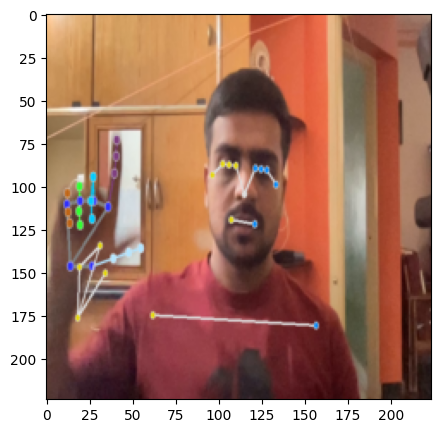

In [50]:
plt.imshow(sample_video[15])

# Load Model - PROD Data

In [51]:
# Now we train the model
def prod_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer'])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_prod_dl = accelerator.prepare(model_pretrained, prod_dl)

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    prod_labels = []
    prod_preds = []

    for batch in tqdm(acclerated_prod_dl):
        with torch.no_grad():
            outputs = accelerated_model(**batch)

        prod_logits = outputs.logits
        prod_softmax = torch.nn.functional.softmax(prod_logits, dim=-1)
        prod_pred = prod_softmax.argmax(-1)
        prod_preds.append(prod_pred)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return prod_preds


In [56]:
predicted_prod_label = prod_function()

loading configuration file /content/drive/MyDrive/Kaggle/SignLanguage/SuccessModels/vivit_pytorch_transformer_GPU_3/config.json
Model config VivitConfig {
  "_name_or_path": "google/vivit-b-16x2",
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "bad",
    "1": "beautiful",
    "2": "big",
    "3": "blind",
    "4": "cheap",
    "5": "cold",
    "6": "curved",
    "7": "deaf",
    "8": "dry",
    "9": "expensive",
    "10": "famous",
    "11": "fast",
    "12": "female",
    "13": "flat",
    "14": "good",
    "15": "happy",
    "16": "healthy",
    "17": "hot",
    "18": "light",
    "19": "long",
    "20": "loose",
    "21": "loud",
    "22": "narrow",
    "23": "new",
    "24": "old",
    "25": "quiet",
    "26": "sad",
    "27": "short",
    "28": "sick",
    "29": "slow",
    "30": "small",
    "31": "tall",
    "32": "ugly",
 

  0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
predicted_prod_label

[tensor([31, 36, 23, 17, 31, 19, 25])]

In [59]:
idx_to_label = model_pretrained.config.id2label

In [67]:
for val in predicted_prod_label[0].numpy():
  #print(val)
  print(idx_to_label[val])

tall
young
new
hot
tall
long
quiet


In [68]:
for path in prod_video_path:
  print(os.path.basename(path).split('/')[-1])

prod_2_tall.mov
prod_3_sad.mov
prod_1_ugly.mov
prod_4_short.mov
prod_5_tall.mov
prod_6_sad.mov
prod_7_quiet.mov
